## Non-Dominated Sorting on Actv/Hemo Predictors
### 1 non-dominated sorting

In [7]:
import os
import sys
import pandas as pd
sys.path.append('../')

from factory import get_sklearn_scorer

In [30]:
import seaborn as sns

In [8]:
data_path = '/home/ulamaca/projects/14_ngs2_mo_pep_opt/assets/processed/mic_data_rf_scored.csv'
df = pd.read_csv(data_path)

array([[<AxesSubplot:xlabel='value', ylabel='value'>,
        <AxesSubplot:xlabel='activity', ylabel='value'>,
        <AxesSubplot:xlabel='p_hemo', ylabel='value'>,
        <AxesSubplot:xlabel='p_actv', ylabel='value'>],
       [<AxesSubplot:xlabel='value', ylabel='activity'>,
        <AxesSubplot:xlabel='activity', ylabel='activity'>,
        <AxesSubplot:xlabel='p_hemo', ylabel='activity'>,
        <AxesSubplot:xlabel='p_actv', ylabel='activity'>],
       [<AxesSubplot:xlabel='value', ylabel='p_hemo'>,
        <AxesSubplot:xlabel='activity', ylabel='p_hemo'>,
        <AxesSubplot:xlabel='p_hemo', ylabel='p_hemo'>,
        <AxesSubplot:xlabel='p_actv', ylabel='p_hemo'>],
       [<AxesSubplot:xlabel='value', ylabel='p_actv'>,
        <AxesSubplot:xlabel='activity', ylabel='p_actv'>,
        <AxesSubplot:xlabel='p_hemo', ylabel='p_actv'>,
        <AxesSubplot:xlabel='p_actv', ylabel='p_actv'>]], dtype=object)

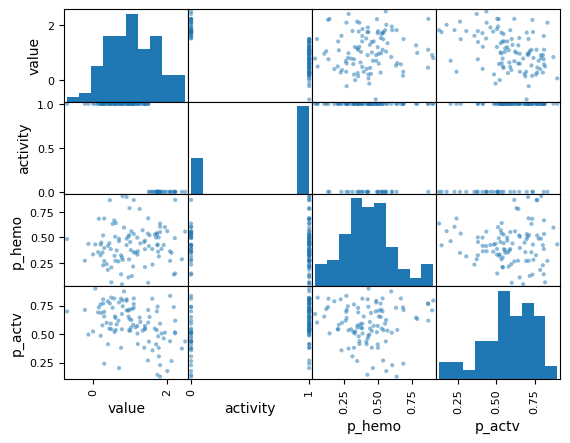

In [11]:
df = df.sample(100, random_state=42)
pd.plotting.scatter_matrix(df)

In [12]:
from dataclasses import dataclass

# each peptide as a Chromosome in GA
@dataclass
class Chromosome:
    id: int
    sequence: str
    scores: dict
    rank: int = -1 # default as -1 (non-ranked)

In [13]:
def convert_df_to_chrms(df):
    chrms = []
    for i, row in df.iterrows():
        x = Chromosome(
            id=i,
            sequence=row['sequence'], 
            scores={
                      'p_hemo': row['p_hemo'],
                      'p_actv': row['p_actv']
                  }
                  )
        chrms.append(x)
    return chrms

chrms = convert_df_to_chrms(df)

In [14]:

from collections import defaultdict
# maximization
# 1 p<q
# 0 p>q
# -1 neigher
def dominance_check(p: Chromosome, q:Chromosome, score_names=['p_hemo', 'p_actv'], dominance_type='max'):
    check_result = -1        

    # 2-M comparison
    p_dominate_q = all([p.scores[score_name] >= q.scores[score_name] for score_name in score_names])
    q_dominate_p = all([p.scores[score_name] <= q.scores[score_name] for score_name in score_names])            

    if p_dominate_q:
        check_result = 1
    elif q_dominate_p:
        check_result = 0        

    return check_result


def sort_nondominate(chromosomes: list[Chromosome]):
    dict_dominance = defaultdict(list)
    dict_n_be_dominated = defaultdict(int)
    
    front_dict = defaultdict(list) # ith > chromosomes in the front
    current_rank = 0        
    
    for p in chromosomes:
        for q in chromosomes:            
            #print(p,q)
            check_p_dominates_q = dominance_check(p,q)            
            if check_p_dominates_q == 1:
                dict_dominance[p.id].append(q)
            elif check_p_dominates_q == 0:
                dict_n_be_dominated[p.id] += 1
            elif check_p_dominates_q == -1:
                pass
            else:
                raise ValueError 
        if dict_n_be_dominated[p.id] == 0:
            p.rank = current_rank
            front_dict[current_rank].append(p)
    
    current_front = front_dict[current_rank]
    
    while len(current_front) > 0:
        new_front = []
        for p in current_front:
            for q in dict_dominance[p.id]:
                dict_n_be_dominated[q.id] -= 1
                nq = dict_n_be_dominated[q.id]
                if nq == 0:
                    q.rank = current_rank + 1
                    new_front.append(q)

        current_rank += 1
        current_front = new_front
        front_dict[current_rank] = current_front
    
    return front_dict

In [31]:
def convert_front_dict_to_df(front_dict, score_names=['p_hemo', 'p_actv']):
    rows = []
    for rank, front in front_dict.items():
        for chrm in front:
            rows.append(chrm.__dict__)
    
    df = pd.DataFrame(rows)    
    for score_name in score_names:
        df[score_name] = df['scores'].apply(lambda x:x[score_name])
    
    return df


In [32]:
front_dict = sort_nondominate(chrms)

rankded_df = convert_front_dict_to_df(front_dict)

In [36]:
front_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [37]:
rankded_df

,id,sequence,scores,rank,p_hemo,p_actv
0,1859,GLRKRLRKFRNKIKEKLKKIGQKIQGFVPKLAPRTDY,"{'p_hemo': 0.4303917249323261, 'p_actv': 0.897...",0,0.430392,0.897871
1,4429,WKLFKKIPKFLHLAKKF,"{'p_hemo': 0.9022069049222616, 'p_actv': 0.793...",0,0.902207,0.793296
2,2426,ILPWKWPWLPWRR,"{'p_hemo': 0.5957923919644458, 'p_actv': 0.873...",0,0.595792,0.873331
3,2617,KIAGKIASIAGKIAKIAGKIAK,"{'p_hemo': 0.6661907160842557, 'p_actv': 0.811...",0,0.666191,0.811657
4,3856,RRWRRWRRWRR,"{'p_hemo': 0.8944308128368145, 'p_actv': 0.707...",1,0.894431,0.707803
...,...,...,...,...,...,...
95,1892,GLWSKIKEAAKTAGLMAMGFVNDMV,"{'p_hemo': 0.3242556980521742, 'p_actv': 0.380...",15,0.324256,0.380329
96,805,FLPIVTNLLSGLLGK,"{'p_hemo': 0.1460065114719983, 'p_actv': 0.506...",15,0.146007,0.506705
97,879,FLSLIPHAINAVGVHAKHF,"{'p_hemo': 0.2852070848190972, 'p_actv': 0.372...",16,0.285207,0.372904
98,4265,VKDLAKFIAKTVAKQGGCYL,"{'p_hemo': 0.3131715313900101, 'p_actv': 0.304...",16,0.313172,0.304822


In [38]:
rankded_df

,id,sequence,scores,rank,p_hemo,p_actv
0,1859,GLRKRLRKFRNKIKEKLKKIGQKIQGFVPKLAPRTDY,"{'p_hemo': 0.4303917249323261, 'p_actv': 0.897...",0,0.430392,0.897871
1,4429,WKLFKKIPKFLHLAKKF,"{'p_hemo': 0.9022069049222616, 'p_actv': 0.793...",0,0.902207,0.793296
2,2426,ILPWKWPWLPWRR,"{'p_hemo': 0.5957923919644458, 'p_actv': 0.873...",0,0.595792,0.873331
3,2617,KIAGKIASIAGKIAKIAGKIAK,"{'p_hemo': 0.6661907160842557, 'p_actv': 0.811...",0,0.666191,0.811657
4,3856,RRWRRWRRWRR,"{'p_hemo': 0.8944308128368145, 'p_actv': 0.707...",1,0.894431,0.707803
...,...,...,...,...,...,...
95,1892,GLWSKIKEAAKTAGLMAMGFVNDMV,"{'p_hemo': 0.3242556980521742, 'p_actv': 0.380...",15,0.324256,0.380329
96,805,FLPIVTNLLSGLLGK,"{'p_hemo': 0.1460065114719983, 'p_actv': 0.506...",15,0.146007,0.506705
97,879,FLSLIPHAINAVGVHAKHF,"{'p_hemo': 0.2852070848190972, 'p_actv': 0.372...",16,0.285207,0.372904
98,4265,VKDLAKFIAKTVAKQGGCYL,"{'p_hemo': 0.3131715313900101, 'p_actv': 0.304...",16,0.313172,0.304822


<AxesSubplot:xlabel='p_actv', ylabel='p_hemo'>

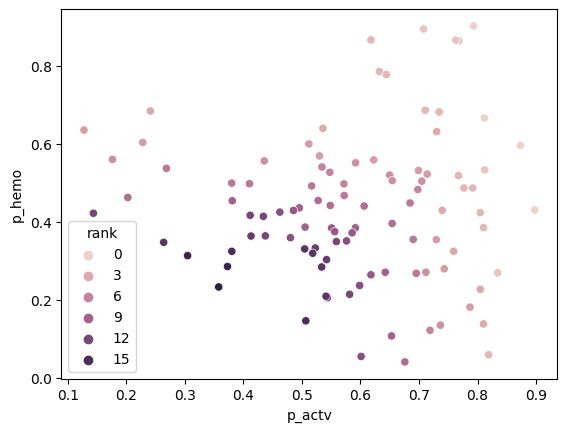

In [34]:
sns.scatterplot(data=rankded_df, x='p_actv', y='p_hemo', hue='rank')